In [6]:
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import yfinance as yf
from finta import TA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate

In [7]:
WINDOW = 16 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'FB'      # Symbol of the desired stock
# INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX']
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'VORTEX']

In [8]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-03-02 04:00:00-05:00,195.500000,196.210000,194.720000,195.900000,195.900000,0
2020-03-02 05:00:00-05:00,195.000000,195.000000,193.300000,193.690000,193.690000,0
2020-03-02 06:00:00-05:00,193.840000,194.940000,192.000000,192.160000,192.160000,0
2020-03-02 07:00:00-05:00,191.600000,191.850000,189.080000,191.750000,191.750000,0
2020-03-02 08:00:00-05:00,191.750000,192.480000,190.900000,191.150000,191.150000,0
...,...,...,...,...,...,...
2021-03-01 13:30:00-05:00,261.700012,265.200012,261.649994,265.199005,265.199005,1578806
2021-03-01 14:30:00-05:00,265.179993,266.649994,264.989990,265.859985,265.859985,2166753
2021-03-01 15:30:00-05:00,265.880005,266.089996,264.079987,264.390015,264.390015,3050263


In [9]:
data.head(9)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-03-02 04:00:00-05:00,195.500000,196.210000,194.720000,195.900000,195.900000,0
2020-03-02 05:00:00-05:00,195.000000,195.000000,193.300000,193.690000,193.690000,0
2020-03-02 06:00:00-05:00,193.840000,194.940000,192.000000,192.160000,192.160000,0
2020-03-02 07:00:00-05:00,191.600000,191.850000,189.080000,191.750000,191.750000,0
2020-03-02 08:00:00-05:00,191.750000,192.480000,190.900000,191.150000,191.150000,0
2020-03-02 09:00:00-05:00,191.180000,195.000000,191.150000,193.850000,193.850000,0
2020-03-02 09:30:00-05:00,194.029999,194.550003,189.070007,189.669998,189.669998,5263019
2020-03-02 10:30:00-05:00,189.619995,193.130005,188.850006,193.009995,193.009995,3886343
2020-03-02 11:30:00-05:00,193.029999,194.059998,191.236099,191.779999,191.779999,2768109


In [388]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-03-02 04:00:00-05:00,195.500000,196.210000,194.720000,195.900000,195.900000,0
2020-03-02 05:00:00-05:00,195.000000,195.000000,193.300000,193.690000,193.690000,0
2020-03-02 06:00:00-05:00,193.840000,194.940000,192.000000,192.160000,192.160000,0
2020-03-02 07:00:00-05:00,191.600000,191.850000,189.080000,191.750000,191.750000,0
2020-03-02 08:00:00-05:00,191.750000,192.480000,190.900000,191.150000,191.150000,0
2020-03-02 09:00:00-05:00,191.180000,195.000000,191.150000,193.850000,193.850000,0
2020-03-02 09:30:00-05:00,194.029999,194.550003,189.070007,189.669998,189.669998,5263019
2020-03-02 10:30:00-05:00,189.619995,193.130005,188.850006,193.009995,193.009995,3886343
2020-03-02 11:30:00-05:00,193.029999,194.059998,191.236099,191.779999,191.779999,2768109


<AxesSubplot:xlabel='Datetime'>

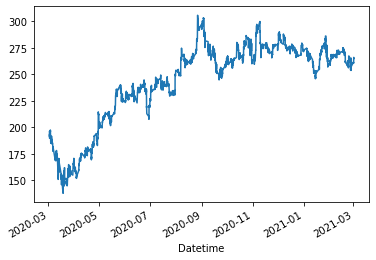

In [389]:
data['close'].plot()

In [390]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = pd.concat([data, ind_data], axis=1)
    # data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    # data['ema15'] = data['close'] / data['close'].ewm(ROWS_TO_PREDICT).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

In [391]:
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,VIm,VIp,ema50,ema21,ema5
Datetime,,,,,,,,,,,,,,,,,
2020-03-02 04:00:00-05:00,195.900000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000
2020-03-02 05:00:00-05:00,193.690000,0.000000,-0.049583,-0.027546,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-66.666667,NaN,NaN,0.994383,0.994459,0.994840
2020-03-02 06:00:00-05:00,192.160000,0.000000,-0.110624,-0.061595,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-84.486874,NaN,NaN,0.991067,0.991237,0.992091
2020-03-02 07:00:00-05:00,191.750000,0.000000,-0.150479,-0.091704,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-116.901408,NaN,NaN,0.991774,0.992011,0.993180
2020-03-02 08:00:00-05:00,191.150000,0.000000,-0.192842,-0.121791,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-69.113940,NaN,NaN,0.991006,0.991315,0.992819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01 12:30:00-05:00,261.730011,56.173487,0.560820,0.343253,82.285753,7.177859e+09,4.179577,4.240011,37.342726,1.642723,115471977.0,34.611490,1.088525,0.910620,0.999195,1.005551,1.003477
2021-03-01 13:30:00-05:00,265.199005,65.664827,0.873983,0.449399,97.909762,7.183462e+09,3.888864,4.009005,56.825789,2.969911,117050783.0,123.716942,1.036919,1.020571,1.012192,1.018005,1.013942
2021-03-01 14:30:00-05:00,265.859985,67.125714,1.162106,0.591941,96.593302,7.184316e+09,3.570293,4.419985,62.660497,3.250606,119217536.0,166.662039,0.976193,1.094230,1.014422,1.019591,1.013687


In [392]:
data.columns

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       'VIm', 'VIp', 'ema50', 'ema21', 'ema5'],
      dtype='object')

In [393]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.2:
        return 1
    if row['close_shift'] -row['close']< -1.2:
        return -1
    else:
        return 0

In [394]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,VIm,VIp,ema50,ema21,ema5,close_shift
Datetime,,,,,,,,,,,,,,,,,,
2020-03-02 04:00:00-05:00,195.900000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,196.14
2020-03-02 05:00:00-05:00,193.690000,0.000000,-0.049583,-0.027546,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-66.666667,NaN,NaN,0.994383,0.994459,0.994840,197.40
2020-03-02 06:00:00-05:00,192.160000,0.000000,-0.110624,-0.061595,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-84.486874,NaN,NaN,0.991067,0.991237,0.992091,195.59
2020-03-02 07:00:00-05:00,191.750000,0.000000,-0.150479,-0.091704,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-116.901408,NaN,NaN,0.991774,0.992011,0.993180,197.05
2020-03-02 08:00:00-05:00,191.150000,0.000000,-0.192842,-0.121791,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-69.113940,NaN,NaN,0.991006,0.991315,0.992819,195.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01 12:30:00-05:00,261.730011,56.173487,0.560820,0.343253,82.285753,7.177859e+09,4.179577,4.240011,37.342726,1.642723,115471977.0,34.611490,1.088525,0.910620,0.999195,1.005551,1.003477,NaN
2021-03-01 13:30:00-05:00,265.199005,65.664827,0.873983,0.449399,97.909762,7.183462e+09,3.888864,4.009005,56.825789,2.969911,117050783.0,123.716942,1.036919,1.020571,1.012192,1.018005,1.013942,NaN
2021-03-01 14:30:00-05:00,265.859985,67.125714,1.162106,0.591941,96.593302,7.184316e+09,3.570293,4.419985,62.660497,3.250606,119217536.0,166.662039,0.976193,1.094230,1.014422,1.019591,1.013687,NaN


In [395]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,VIm,VIp,ema50,ema21,ema5,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,
2020-03-02 04:00:00-05:00,195.900000,NaN,0.000000,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,196.14,0
2020-03-02 05:00:00-05:00,193.690000,0.000000,-0.049583,-0.027546,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-66.666667,NaN,NaN,0.994383,0.994459,0.994840,197.40,1
2020-03-02 06:00:00-05:00,192.160000,0.000000,-0.110624,-0.061595,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-84.486874,NaN,NaN,0.991067,0.991237,0.992091,195.59,1
2020-03-02 07:00:00-05:00,191.750000,0.000000,-0.150479,-0.091704,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-116.901408,NaN,NaN,0.991774,0.992011,0.993180,197.05,1
2020-03-02 08:00:00-05:00,191.150000,0.000000,-0.192842,-0.121791,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.0,-69.113940,NaN,NaN,0.991006,0.991315,0.992819,195.95,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01 12:30:00-05:00,261.730011,56.173487,0.560820,0.343253,82.285753,7.177859e+09,4.179577,4.240011,37.342726,1.642723,115471977.0,34.611490,1.088525,0.910620,0.999195,1.005551,1.003477,NaN,0
2021-03-01 13:30:00-05:00,265.199005,65.664827,0.873983,0.449399,97.909762,7.183462e+09,3.888864,4.009005,56.825789,2.969911,117050783.0,123.716942,1.036919,1.020571,1.012192,1.018005,1.013942,NaN,0
2021-03-01 14:30:00-05:00,265.859985,67.125714,1.162106,0.591941,96.593302,7.184316e+09,3.570293,4.419985,62.660497,3.250606,119217536.0,166.662039,0.976193,1.094230,1.014422,1.019591,1.013687,NaN,0


In [396]:
# Class divide
data['class_column'].value_counts()

 1    1699
-1    1548
 0     886
Name: class_column, dtype: int64

In [397]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()

In [398]:
data['class_column'].value_counts()


 1    1663
-1    1511
 0     857
Name: class_column, dtype: int64

In [399]:
def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

def init_classifiers():
    classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
    classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best')
    classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='gini')
    classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='gini')
    classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
    classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
    classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)

In [400]:

features = [x for x in data.columns if x not in ['class_column']]
num_step = 100 #  (len(data) / num_train  =  number of train-test sets
len_set = 300 # Length of each train-test set

score = defaultdict(list)
step_headers = []
i = 0

while True:
    df = data.iloc[i * num_step : (i * num_step) + len_set]
    print("step: ", i * num_step, (i * num_step) + len_set)
    print(df['class_column'].value_counts())
    if len(df) < len_set:
        break


    step_headers.append(f'<{i * num_step, (i * num_step) + len_set}>')
    y = df['class_column']
    x = df[features]
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.33, shuffle=False)
    classifiers = dict()
    init_classifiers()
    predictions= dict()
    for k,v in classifiers.items():
        print("Calculate: ", k)
        train_model(v,x_train,y_train)
        predictions[k] = v.predict(x_test)
        score[k].append(accuracy_score(y_test.values, predictions[k]))

    i += 1

step:  0 300
-1    175
 1    100
 0     25
Name: class_column, dtype: int64
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  RandomForestClassifier 1
Calculate:  RandomForestClassifier 2
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifier 2
Calculate:  GradientBoostingClassifier 3
step:  100 400
-1    151
 1    118
 0     31
Name: class_column, dtype: int64
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  RandomForestClassifier 1
Calculate:  RandomForestClassifier 2
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifier 2
Calculate:  GradientBoostingClassifier 3
step:  200 500
 1    142
-1    105
 0     53
Name: class_column, dtype: int64
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  RandomForestClassifier 1
Calculate:  RandomForestClassifier 2
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifie

In [401]:
# print(score['DecisionTreeClassifier 1'])
# print(score['DecisionTreeClassifier 2'])

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type",] + step_headers
score_df = pd.DataFrame(score.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['Accuracy'].tolist(), index= score_df.index, columns=step_headers)
score_df = score_df.drop('Accuracy', 1)
f_out = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['mean'] = f_out.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out,headers2 , tablefmt="psql"))

+----+------------------------------+--------------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
|    | Classifier type              |   <(0, 300)> |   <(100, 400)> |   <(200, 500)> |   <(300, 600)> |   <(400, 700)> |   <(500, 800)> |   <(600, 900)> |   <(700, 1000)> |   <(800, 1100)> |   <(900, 1200)> |   <(1000, 1300)> |   <(1100, 1400)> |  